# profiling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import random

def randt(n):
    return tuple(random() for _ in range(n))

def isclose(*a):
    return all(np.isclose(a[0], ai) for ai in a[1:])

def allclose(*a):
    return all(np.allclose(a[0], ai) for ai in a[1:])

def compare(x, *ys, title=None):
    fig, axs = plt.subplots(ncols=2, sharex=True)
    for i, y in enumerate(ys):
        axs[0].scatter(x, np.multiply(y, 1e3), marker='o', s=(72./fig.dpi)**2, label=f'$f_{i}$')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('$n$ / 1')
    axs[0].set_ylabel('$t$ / ms')
    axs[0].legend()
    axs[0].set_title('Absolute')
    
    for i, y in enumerate(ys):
        axs[1].scatter(x, np.divide(ys[0], y), marker='o', s=(72./fig.dpi)**2, label=f'$f_0$ / $f_{i}$')
    #axs[1].axhline(1, linestyle='--', lw=0.5)
    axs[1].set_yscale('log')
    axs[1].set_xlabel('$n$ / 1')
    axs[1].set_ylabel('$t$ / 1')
    axs[1].set_title('Relative')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

#def measure(supplier, *f, N=10000, n=4):
#    x, y = [], [[] for _ in range(len(f))]
#    for _ in range(N):
#        args = supplier()
#        x += [args[0]]
#        args = args[1:]
#        try:
#            assert all(np.isclose(f[0](*args), fi(*args)) for fi in f[1:])
#        except ValueError:
#            assert all(np.allclose(f[0](*args), fi(*args)) for fi in f[1:])
#        for fi, yi in zip(f, y):
#            yi += [timeit(lambda: fi(*args), number=n) / n]
#    return x, *y

## trim

In [2]:
def trim0(v, tol):
    while v and abs(v[-1])<=tol:
        v = v[:-1]
    return v

def trim1(v, tol):
    return v[:len(v)-next((i for i, vi in enumerate(reversed(v)) if abs(vi)>tol), len(v))]

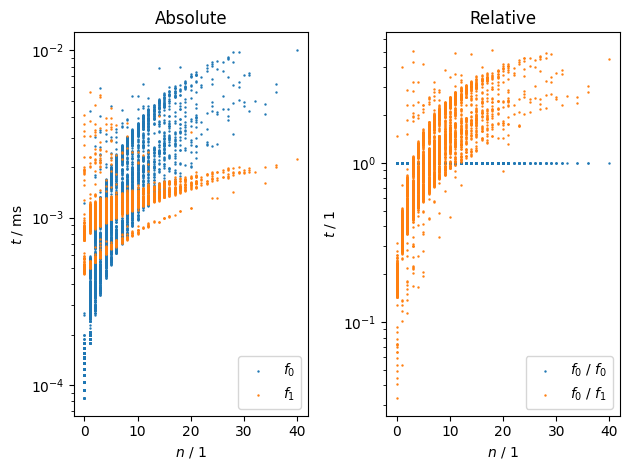

In [3]:
from random import randint
from timeit import timeit

N = 4 #number of executions in timeit
tol = 0.8
x, y0, y1 = [], [], []
for _ in range(10000):
    v = randt(randint(0, 100))
    assert trim0(v, tol) == trim1(v, tol)
    x += [len(v)-len(trim0(v, tol))]
    y0 += [timeit(lambda: trim0(v, tol), number=N) / N]
    y1 += [timeit(lambda: trim1(v, tol), number=N) / N]

compare(x, y0, y1)

## dot

In [4]:
from itertools import starmap
from operator import mul

def dot0(v, w):
    return sum(map(mul, v, w))

def dot1(v, w):
    #https://docs.python.org/3/library/itertools.html
    return sum(starmap(mul, zip(v, w)))

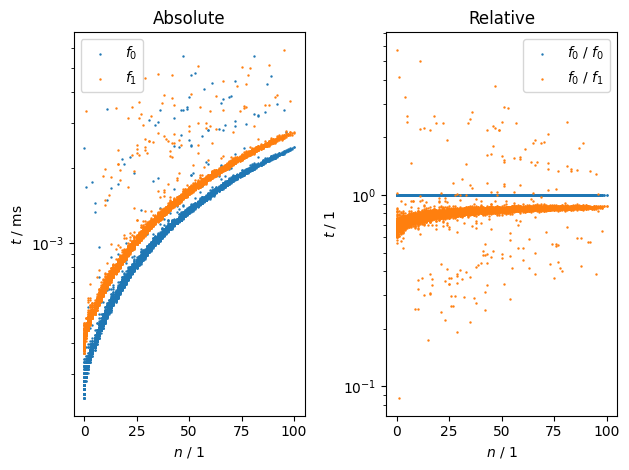

In [5]:
x, y0, y1 = [], [], []
for _ in range(10000):
    v, w = randt(randint(0, 100)), randt(randint(0, 100))
    assert isclose(dot0(v, w), dot1(v, w))
    x += [min(len(v), len(w))]
    y0 += [timeit(lambda: dot0(v, w), number=N) / N]
    y1 += [timeit(lambda: dot1(v, w), number=N) / N]

compare(x, y0, y1)

## norm

In [6]:
from math import sqrt, sumprod, hypot

def norm0(v):
    return hypot(*v)

def norm1(v):
    return sqrt(sumprod(v, v))

def dot(v, w):
    return sum(map(mul, v, w))

def norm2(v):
    return sqrt(dot(v, v))

def norm3(v):
    return sqrt(sum(vi**2 for vi in v))

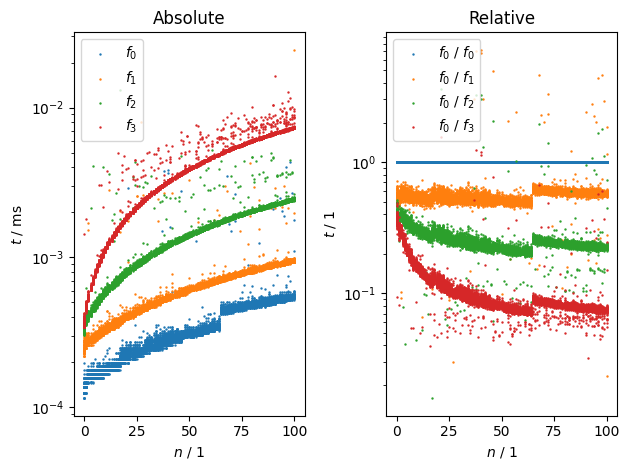

In [7]:
x, y0, y1, y2, y3 = [], [], [], [], []
for _ in range(10000):
    v = randt(randint(0, 100))
    assert isclose(norm0(v), norm1(v), norm2(v), norm3(v))
    x += [len(v)]
    y0 += [timeit(lambda: norm0(v), number=N) / N]
    y1 += [timeit(lambda: norm1(v), number=N) / N]
    y2 += [timeit(lambda: norm2(v), number=N) / N]
    y3 += [timeit(lambda: norm3(v), number=N) / N]

compare(x, y0, y1, y2, y3)

## add

In [8]:
from itertools import zip_longest
from operator import add

def add0(v, w):
    return tuple(starmap(add, zip_longest(v, w, fillvalue=0)))

def add1(v, w):
    return tuple(vi+wi for vi, wi in zip_longest(v, w, fillvalue=0))

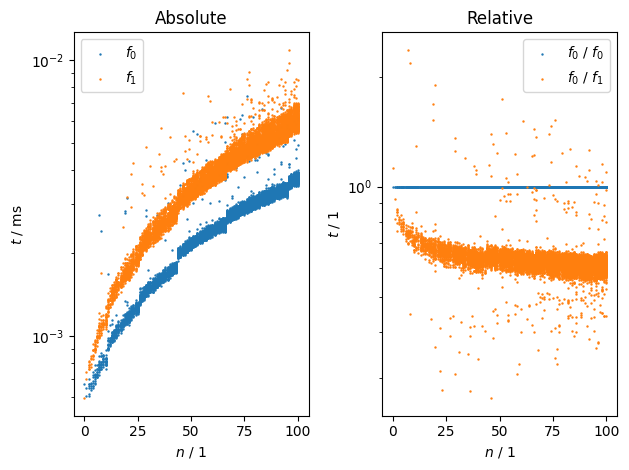

In [9]:
x, y0, y1 = [], [], []
for _ in range(10000):
    v, w = randt(randint(0, 100)), randt(randint(0, 100))
    assert allclose(add0(v, w), add1(v, w))
    x += [max(len(v), len(w))]
    y0 += [timeit(lambda: add0(v, w), number=N) / N]
    y1 += [timeit(lambda: add1(v, w), number=N) / N]

compare(x, y0, y1)

## addscalar

In [10]:
from itertools import repeat

def addscalar0(v, a):
    return tuple(map(add, v, repeat(a)))

def addscalar1(v, a):
    return tuple(vi+a for vi in v)

def addscalar2(v, a):
    return tuple(map(lambda vi: vi+a, v))

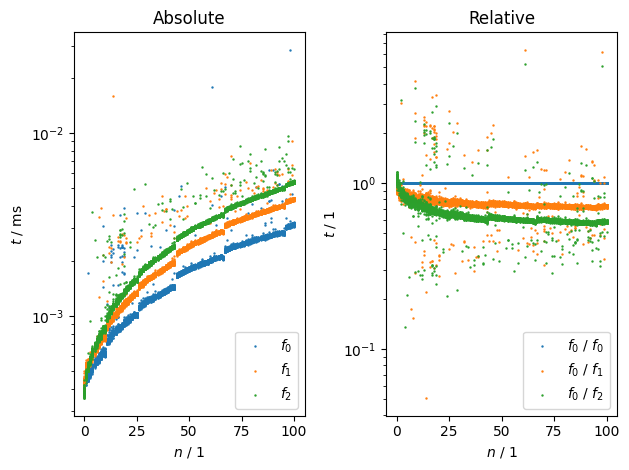

In [11]:
x, y0, y1, y2 = [], [], [], []
for _ in range(10000):
    v, a = randt(randint(0, 100)), random()
    assert allclose(addscalar0(v, a), addscalar1(v, a), addscalar2(v, a))
    x += [len(v)]
    y0 += [timeit(lambda: addscalar0(v, a), number=N) / N]
    y1 += [timeit(lambda: addscalar1(v, a), number=N) / N]
    y2 += [timeit(lambda: addscalar2(v, a), number=N) / N]

compare(x, y0, y1, y2)

## sub

In [12]:
from operator import sub

def sub0(v, w):
    return tuple(starmap(sub, zip_longest(v, w, fillvalue=0)))

def sub1(v, w):
    return tuple(vi-wi for vi, wi in zip_longest(v, w, fillvalue=0))

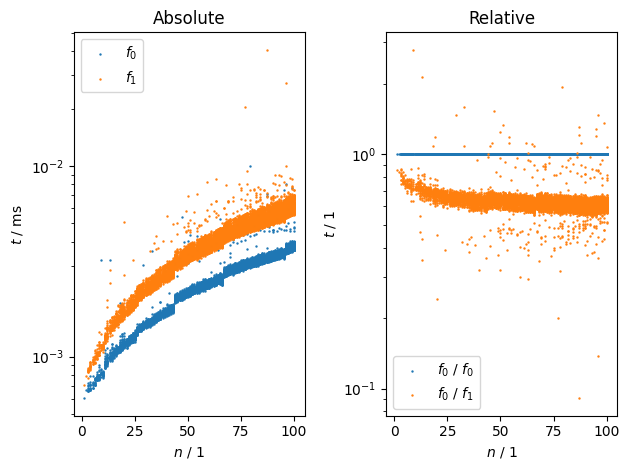

In [13]:
x, y0, y1 = [], [], []
for _ in range(10000):
    v, w = randt(randint(0, 100)), randt(randint(0, 100))
    assert allclose(sub0(v, w), sub1(v, w))
    x += [max(len(v), len(w))]
    y0 += [timeit(lambda: sub0(v, w), number=N) / N]
    y1 += [timeit(lambda: sub1(v, w), number=N) / N]

compare(x, y0, y1)

## subscalar

In [14]:
def subscalar0(v, a):
    return tuple(map(sub, v, repeat(a)))

def subscalar1(v, a):
    return tuple(vi-a for vi in v)

def subscalar2(v, a):
    return tuple(map(lambda vi: vi-a, v))

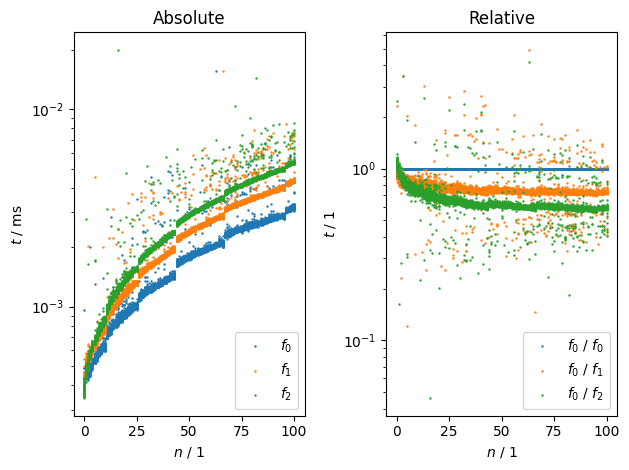

In [15]:
x, y0, y1, y2 = [], [], [], []
for _ in range(10000):
    v, a = randt(randint(0, 100)), random()
    assert allclose(subscalar0(v, a), subscalar1(v, a), subscalar2(v, a))
    x += [len(v)]
    y0 += [timeit(lambda: subscalar0(v, a), number=N) / N]
    y1 += [timeit(lambda: subscalar1(v, a), number=N) / N]
    y2 += [timeit(lambda: subscalar2(v, a), number=N) / N]

compare(x, y0, y1, y2)

## mul

In [16]:
def mul0(a, v):
    return tuple(map(mul, repeat(a), v))

def mul1(a, v):
    return tuple(a*vi for vi in v)

def mul2(a, v):
    return tuple(map(lambda vi: a*vi, v))

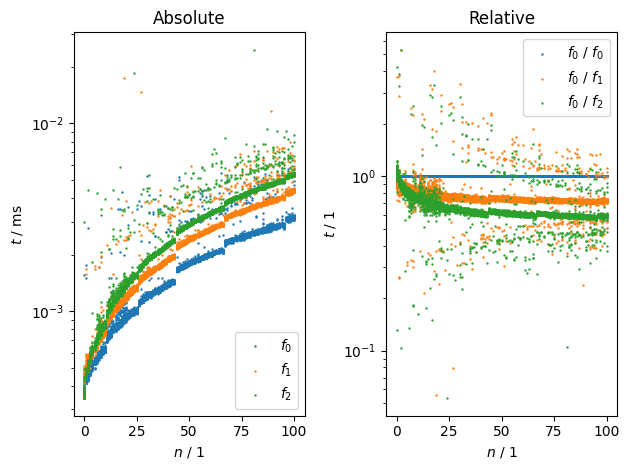

In [17]:
x, y0, y1, y2 = [], [], [], []
for _ in range(10000):
    a, v = random(), randt(randint(0, 100))
    assert allclose(mul0(a, v), mul1(a, v), mul2(a, v))
    x += [len(v)]
    y0 += [timeit(lambda: mul0(a, v), number=N) / N]
    y1 += [timeit(lambda: mul1(a, v), number=N) / N]
    y2 += [timeit(lambda: mul2(a, v), number=N) / N]

compare(x, y0, y1, y2)

## mulelementwise

In [18]:
def mulelementwise0(v, w):
    return tuple(map(mul, v, w))

def mulelementwise1(v, w):
    return tuple(vi*wi for vi, wi in zip(v, w))

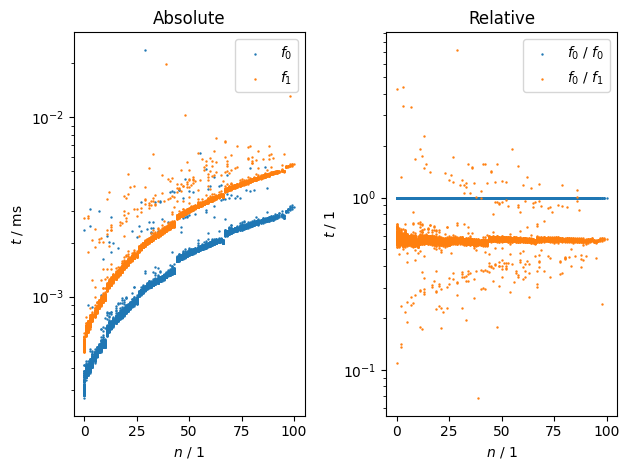

In [19]:
x, y0, y1 = [], [], []
for _ in range(10000):
    v, w = randt(randint(0, 100)), randt(randint(0, 100))
    assert allclose(mulelementwise0(v, w), mulelementwise1(v, w))
    x += [min(len(v), len(w))]
    y0 += [timeit(lambda: mulelementwise0(v, w), number=N) / N]
    y1 += [timeit(lambda: mulelementwise1(v, w), number=N) / N]

compare(x, y0, y1)

# div

In [20]:
from operator import truediv

def div0(v, a):
    return tuple(map(truediv, v, repeat(a)))

def div1(v, a):
    return tuple(vi/a for vi in v)

def div2(v, a):
    return tuple(map(lambda vi: vi/a, v))

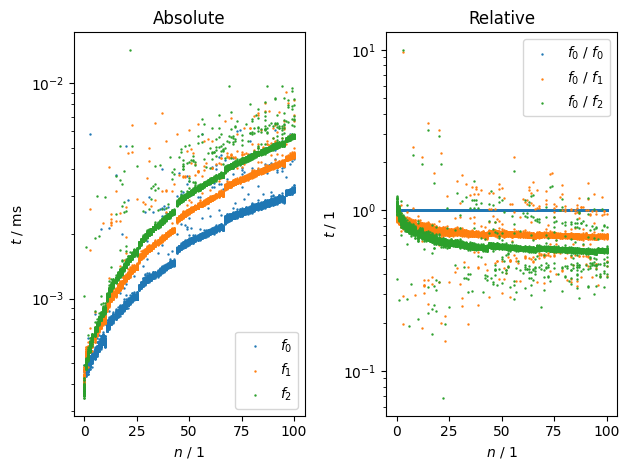

In [21]:
x, y0, y1, y2 = [], [], [], []
for _ in range(10000):
    a, v = random(), randt(randint(0, 100))
    assert allclose(div0(v, a), div1(v, a), div2(v, a))
    x += [len(v)]
    y0 += [timeit(lambda: div0(v, a), number=N) / N]
    y1 += [timeit(lambda: div1(v, a), number=N) / N]
    y2 += [timeit(lambda: div2(v, a), number=N) / N]

compare(x, y0, y1, y2)

## divelementwise

In [22]:
def divelementwise0(v, w):
    return tuple(map(truediv, v, w))

def divelementwise1(v, w):
    return tuple(vi/wi for vi, wi in zip(v, w))

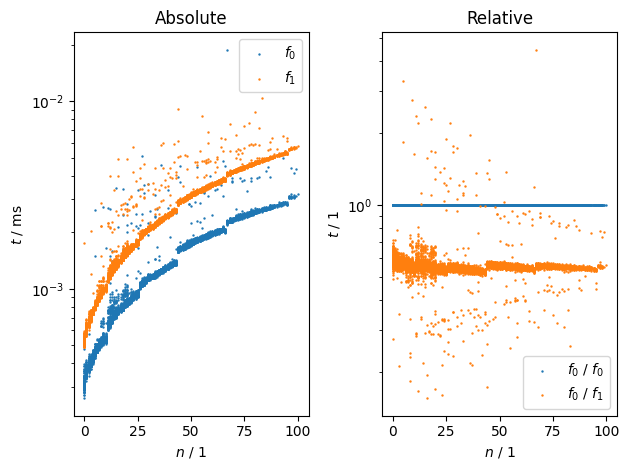

In [23]:
x, y0, y1 = [], [], []
for _ in range(10000):
    v, w = randt(randint(0, 100)), randt(randint(0, 100))
    assert allclose(divelementwise0(v, w), divelementwise1(v, w))
    x += [min(len(v), len(w))]
    y0 += [timeit(lambda: divelementwise0(v, w), number=N) / N]
    y1 += [timeit(lambda: divelementwise1(v, w), number=N) / N]

compare(x, y0, y1)